# Plot summer peaks and winter peaks along the centerline with weather and terminus data

To-do: 
- Double check that water years are correctly applied
- Transpose the figure

In [1]:
import xarray as xr
import rioxarray as rxr
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import geopandas as gpd
import scipy

## Load datasets

In [2]:
data_path = '/Users/raineyaberle/Research/Hubbard/'
out_path = '/Users/raineyaberle/Research/Hubbard/figures/'
crs = 'EPSG:3338'

# -----Velocity
v_fn = os.path.join(data_path, 'velocity', 'Hubbard_5eminus5.nc')
v = xr.load_dataset(v_fn)
v["v"] = np.sqrt(v.vx**2 + v.vy**2).fillna(0)
v["month"] = v.time.dt.month
v["year"] = v.time.dt.year
v["doy"] = v.time.dt.dayofyear
v = v.rio.write_crs(rxr.open_rasterio(v_fn).rio.crs)
v = v.rio.reproject(crs)
v = xr.where(v > 1e10, np.nan, v)

# -----Weather
## Air temperature
air_fn = os.path.join(data_path, 'weather', 'wx_Haenke_2014_2022_nogap.csv')
air = pd.read_csv(air_fn)
# remove empty columns
air = air[[x for x in list(air.columns) if 'Unnamed' not in x]]
air.dropna(inplace=True)
# resample to daily resolution
air['GMT'] = pd.DatetimeIndex(air['GMT'])
air.rename(columns={'GMT':'datetime'}, inplace=True)
air.drop(columns={'AKDT'}, inplace=True)
air.set_index('datetime', inplace=True)
air = air.resample('1D').mean()
# convert Fahrenheit to C
air['Temp-AVG_C'] = (air['Temp-AVG'] - 32) * 5/9
# calculate PDDs and cumsum(PDDs)
air['Water Year'] = [dt.year if dt.month < 10 else dt.year + 1 for dt in air.index]
air['PDD'] = [temp if temp > 0 else 0 for temp in air['Temp-AVG_C']]
air['PDD_cumsum'] = air.groupby('Water Year')['PDD'].cumsum()
air.reset_index(inplace=True)
# ### Precipitation - Using Yakutat, Haenke only has data for 2012-2013
# precip_fn = os.path.join(data_path, 'weather', 'Yakutat_2000_2023.csv')
# precip = pd.read_csv(precip_fn)
# precip.drop(columns={'Unnamed: 0'}, inplace=True)
# precip.rename(columns={'Date_Time':'datetime'}, inplace=True)
# precip['datetime'] = pd.to_datetime(precip['datetime'])
# # interpolate missing values
# precip['precip_accum_24_hour_set_1'] = precip['precip_accum_24_hour_set_1'].interpolate()
# # calculate cumulative annual precip
# precip['Water Year'] = [year if year < 10 else year+1 for year in pd.DatetimeIndex(precip['datetime']).year]
# precip['precip_cumsum_mm'] = precip.groupby('Water Year')['precip_accum_24_hour_set_1'].cumsum()
# precip.dropna(inplace=True)
wx = air#.merge(precip, on='datetime')

# -----Centerline
cl_fn = os.path.join(data_path, 'velocity', 'center_50m.gpkg')
cl_gdf = gpd.read_file(cl_fn)
cl_gdf = cl_gdf.to_crs(crs)
cl_x, cl_y = cl_gdf.geometry[0].coords.xy[0], cl_gdf.geometry[0].coords.xy[1]

# -----Terminus
term_fn = os.path.join(data_path, 'terminus', 'terminus_position_smooth.csv')
term = pd.read_csv(term_fn)
term['Date'] = pd.to_datetime(term['Date'])
term.drop_duplicates(inplace=True)
term['Mean_position_m'] = term[['section_A [m]', 'section_B1 [m]', 'section_B2 [m]', 'section_C [m]']].mean(axis=1)
term['Mean_position_section_B_m'] = term[['section_B1 [m]', 'section_B2 [m]']].mean(axis=1)
# Calculate the negative to measure retreat as positive
term['Mean_retreat_m'] = -term['Mean_position_m']
term['Mean_retreat_section_B_m'] = -term['Mean_position_section_B_m']
# Resample to daily
term.set_index('Date', inplace=True)
term = term.resample('1D').interpolate('time')
# Calculate mean retreat rate [m/d]
term['Mean_retreat_rate_m/d'] = term['Mean_retreat_m'].diff()

## Calculate winter and summer speed peaks

Stolen from Amy's code in the `doublestrength` folder

In [3]:
years = np.arange(2016,2022)

# ----Summer
summer_peak_cl_df = pd.DataFrame()
for year in years:
    summer_mask = np.logical_and(
        np.logical_and(v.month >= 4, v.month <= 6),
        v.year == year+1,
    )
    summer_velocities = v.v[summer_mask, :, :]
    summer_peak = summer_velocities.max(dim='time')

     # Sample along centerline points
    summer_peak_cl = np.array([float(summer_peak.sel(x=x, y=y, method='nearest').data) 
                               for (x,y) in list(zip(cl_gdf.geometry[0].coords.xy[0], cl_gdf.geometry[0].coords.xy[1]))])
    df = pd.DataFrame({str(year): summer_peak_cl})
    summer_peak_cl_df = pd.concat([summer_peak_cl_df, df], axis=1)
summer_peak_cl_df

,2016,2017,2018,2019,2020,2021
0,2589.584507,2658.257833,2615.857338,2606.187610,2641.227823,2608.982356
1,2589.584507,2658.257833,2615.857338,2606.187610,2641.227823,2608.982356
2,2591.857594,2668.263050,2609.900133,2604.031920,2668.415441,2595.525942
3,2591.857594,2668.263050,2609.900133,2604.031920,2668.415441,2595.525942
4,2591.857594,2668.263050,2609.900133,2604.031920,2668.415441,2595.525942
...,...,...,...,...,...,...
354,2904.409431,2992.451042,3138.740800,2699.075368,2986.300441,3369.390200
355,2904.409431,2992.451042,3138.740800,2699.075368,2986.300441,3369.390200
356,2816.968702,3275.213364,3430.683749,2734.695955,3204.808498,3348.168593
357,2816.968702,3275.213364,3430.683749,2734.695955,3204.808498,3348.168593


In [4]:
# -----Winter
winter_peak_cl_df = pd.DataFrame()
for i, year in enumerate(years):
    winter_mask = np.logical_or(
        np.logical_and(v.month >= 10, v.year == year),
        np.logical_and(v.month <= 2, v.year == year+1)
    )
    winter_velocities = v.v[winter_mask, :, :]
    winter_peak = winter_velocities.max(dim='time')

    # Sample along centerline points
    winter_peak_cl = np.array([float(winter_peak.sel(x=x, y=y, method='nearest').data) 
                               for (x,y) in list(zip(cl_gdf.geometry[0].coords.xy[0], cl_gdf.geometry[0].coords.xy[1]))])
    df = pd.DataFrame({str(year): winter_peak_cl})
    winter_peak_cl_df = pd.concat([winter_peak_cl_df, df], axis=1)
winter_peak_cl_df

,2016,2017,2018,2019,2020,2021
0,2408.209751,2334.068934,2296.400320,2294.823189,2346.293546,2249.403095
1,2408.209751,2334.068934,2296.400320,2294.823189,2346.293546,2249.403095
2,2425.574678,2337.837489,2299.855765,2286.319418,2341.929193,2263.892654
3,2425.574678,2337.837489,2299.855765,2286.319418,2341.929193,2263.892654
4,2425.574678,2337.837489,2299.855765,2286.319418,2341.929193,2263.892654
...,...,...,...,...,...,...
354,2568.133701,3161.349590,2382.549538,3419.771034,3079.440403,2906.845725
355,2568.133701,3161.349590,2382.549538,3419.771034,3079.440403,2906.845725
356,2595.608277,3216.047848,2434.321920,3357.799516,3453.824117,2955.962402
357,2595.608277,3216.047848,2434.321920,3357.799516,3453.824117,2955.962402


## Grab mean annual peaks

In [5]:
winter_peak_cl_mean = winter_peak_cl_df.mean()
summer_peak_cl_mean = summer_peak_cl_df.mean()
pdd_max = wx.groupby(pd.DatetimeIndex(wx['datetime']).year)['PDD_cumsum'].max()
term_max = term.groupby(pd.DatetimeIndex(term.index).year)['Mean_retreat_m'].max()
term_retreat_max = term.groupby(pd.DatetimeIndex(term.index).year)['Mean_retreat_rate_m/d'].max()
# subset to years
pdd_max = pdd_max.loc[years]

## Plot mean speed peaks vs. weather and terminus

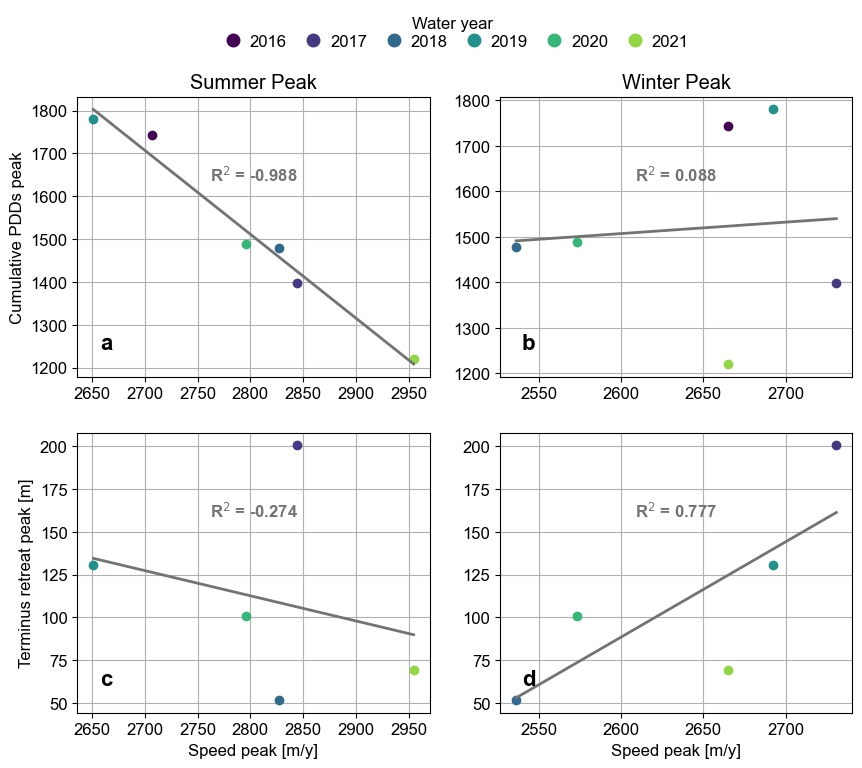

Figure saved to file: /Users/raineyaberle/Research/Hubbard/figures/speed_peaks_vs_weather_terminus.png


In [6]:
retreat_rate = False # whether to use terminus RATE or just terminus retreat magnitude

fontsize=12
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
fig, ax = plt.subplots(2,2,figsize=(10,8))
cmap = plt.cm.viridis
markersize=10
regression_color = '#737373'

if retreat_rate:
    Xdfs = [pdd_max, term_retreat_max]
    labels = ['Cumulative PDDs peak', 'Terminus retreat rate peak [m/d]']
else:
    Xdfs = [pdd_max, term_max]
    labels = ['Cumulative PDDs peak', 'Terminus retreat peak [m]']
panel_labels = [['a', 'b'], ['c', 'd']]
for i in range(len(Xdfs)):
    Xdf = Xdfs[i]
    label = labels[i]
    for j, df in enumerate([summer_peak_cl_mean, winter_peak_cl_mean]):
        # scatter plot
        for k in range(len(years)):
            if i==1:
                if years[k]==2016:
                    continue
                ax[i,j].plot(df.values[k], Xdf.values[k-1], 'o', color=cmap(k/len(years)), label=str(years[k]))
            else:
                ax[i,j].plot(df.values[k], Xdf.values[k], 'o', color=cmap(k/len(years)), label=str(years[k]))
        # linear regression lines
        if i==1:
            X, y = df.values[1:], Xdf.values
        else:
            X, y = df.values, Xdf.values
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X, y)
        Xmod = np.linspace(np.nanmin(X), np.nanmax(X), num=100)
        ymod = Xmod*slope + intercept
        ax[i,j].plot(Xmod, ymod, '-', color=regression_color, linewidth=2)
        ax[i,j].text((ax[i,j].get_xlim()[1] - ax[i,j].get_xlim()[0])*0.5 + ax[i,j].get_xlim()[0], 
                     (ax[i,j].get_ylim()[1] - ax[i,j].get_ylim()[0])*0.7 + ax[i,j].get_ylim()[0], 
                     f'R$^2$ = {np.round(r_value, 3)}', horizontalalignment='center', fontweight='bold', color=regression_color)
        ax[i,j].text((ax[i,j].get_xlim()[1] - ax[i,j].get_xlim()[0])*0.1 + ax[i,j].get_xlim()[0], 
                     (ax[i,j].get_ylim()[1] - ax[i,j].get_ylim()[0])*0.1 + ax[i,j].get_ylim()[0], 
                     panel_labels[i][j], horizontalalignment='right', fontweight='bold', fontsize=fontsize+4)        
        
    # adjust axes
    ax[i,0].grid()
    ax[i,0].set_ylabel(labels[i])
    ax[i,1].grid()

ax[0,0].set_title('Summer Peak')
ax[0,1].set_title('Winter Peak')
ax[1,0].set_xlabel('Speed peak [m/y]')
ax[1,1].set_xlabel('Speed peak [m/y]')

# add legend
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncols=len(years), title='Water year', 
           labelspacing=0.2, columnspacing=0.6, handletextpad = 0.0, markerscale=1.5,
           bbox_to_anchor=[0.4, 0.8, 0.2, 0.2], frameon=False)

plt.show()

# Save figure
if retreat_rate:
    fig_fn = os.path.join(out_path, 'speed_peaks_vs_weather_terminus_rate.png')
else:
    fig_fn = os.path.join(out_path, 'speed_peaks_vs_weather_terminus.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_fn)

## Calculate cross-correlation between speed, terminus, and PDDs

In [7]:
# -----Calculate mean velocity for a centerline segment near the terminus
cl_segment_coords = list(zip(cl_gdf.geometry[0].coords.xy[0][-100:], cl_gdf.geometry[0].coords.xy[1][-100:]))
v_cl_segment_mean = np.array([v.sel(x=x, y=y, method='nearest').v.data for (x,y) in cl_segment_coords])
v_cl_segment_mean = np.nanmean(v_cl_segment_mean, axis=0)
# combine in dataframe
v_mean_df = pd.DataFrame({'Date': v.time.data,
                     'v': v_cl_segment_mean})
# remove zero values
v_mean_df.loc[v_mean_df['v']==0, 'v'] = np.nan
v_mean_df.dropna(inplace=True)
if type(v_mean_df.index)!=pd.DatetimeIndex:
    v_mean_df.set_index('Date', inplace=True)
v_mean_df.reset_index(inplace=True)

# -----Resample terminus to daily
if type(term.index)!=pd.DatetimeIndex:
    term.set_index('Date', inplace=True)
term_resamp = term.resample('1D').interpolate()
term_resamp.reset_index(inplace=True)

# -----Set Date as index in weather df
wx.rename(columns={'datetime':'Date'}, inplace=True)
wx.reset_index(inplace=True)

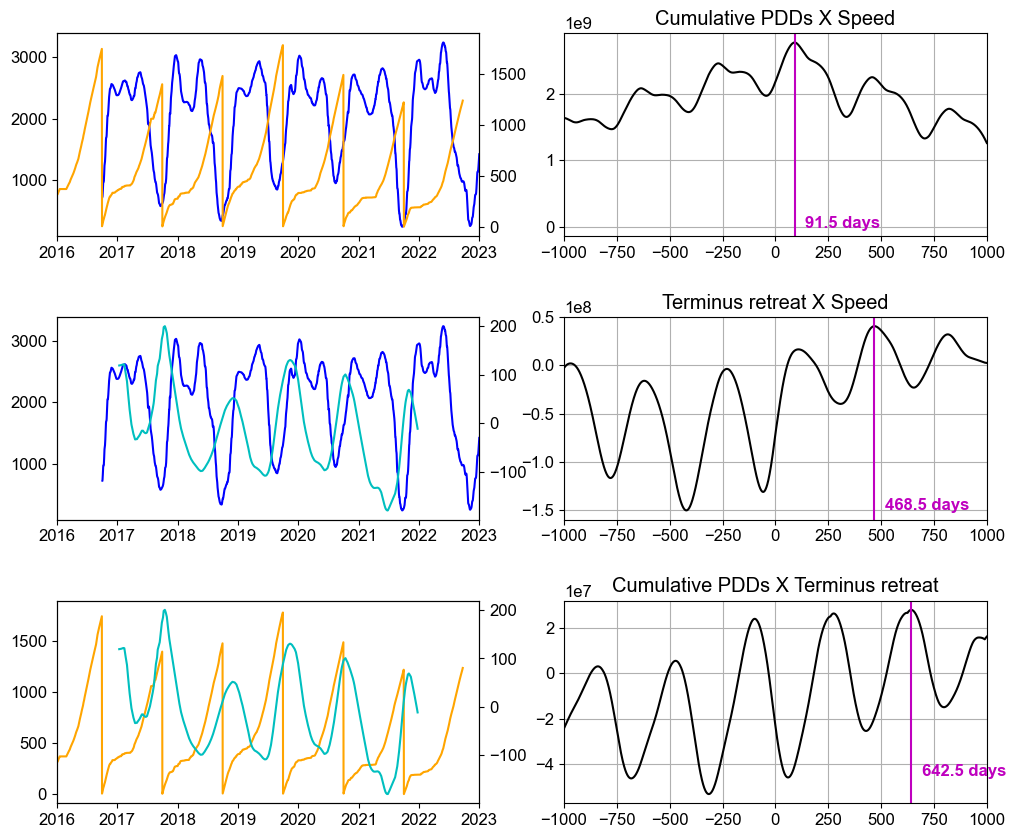

In [8]:
# -----Calculate X-corr and plot
def Xcorr(df1, col1, df2, col2):
    df_merged = df1.merge(df2, on='Date')
    xcorr = scipy.signal.correlate(df_merged[col1], df_merged[col2], mode='full', method='auto')
    days = np.arange(-len(xcorr)/2, len(xcorr)/2)
    Ipeak = np.argwhere(xcorr==np.nanmax(xcorr))
    xcorr_peak, days_peak = xcorr[Ipeak], days[Ipeak]

    return xcorr, days, xcorr_peak, days_peak

fig, ax = plt.subplots(3, 2, figsize=(12,10))
### pdd-speed
xcorr, days, xcorr_peak, days_peak = Xcorr(wx, 'PDD_cumsum', v_mean_df, 'v')
ax[0,0].plot(v_mean_df['Date'], v_mean_df['v'], '-b')
ax2 = ax[0,0].twinx()
ax2.plot(wx['Date'], wx['PDD_cumsum'], '-', color='orange')
ax[0,1].plot(days, xcorr, '-k')
ax[0,1].axvline(days_peak, color='m')
ax[0,1].text(days_peak + 50, ax[0,1].get_ylim()[0]*0.1, f'{days_peak[0][0]} days', color='m', fontweight='bold')
ax[0,1].set_title('Cumulative PDDs X Speed')
ax[0,1].grid()
### terminus-speed
xcorr, days, xcorr_peak, days_peak = Xcorr(v_mean_df, 'v', term_resamp, 'Mean_retreat_m')
ax[1,0].plot(v_mean_df['Date'], v_mean_df['v'], '-b')
ax2 = ax[1,0].twinx()
ax2.plot(term_resamp['Date'], term_resamp['Mean_retreat_m'], '-c')
ax[1,1].plot(days, xcorr, '-k')
ax[1,1].axvline(days_peak, color='m')
ax[1,1].text(days_peak + 50, -1.5e8, f'{days_peak[0][0]} days', color='m', fontweight='bold')
ax[1,1].set_title('Terminus retreat X Speed')
ax[1,1].grid()
### pdd-terminus
xcorr, days, xcorr_peak, days_peak = Xcorr(wx, 'PDD_cumsum', term_resamp, 'Mean_retreat_m')
ax[2,0].plot(wx['Date'], wx['PDD_cumsum'], '-', color='orange')
ax2 = ax[2,0].twinx()
ax2.plot(term_resamp['Date'], term_resamp['Mean_retreat_m'], '-c')
ax[2,1].plot(days, xcorr, '-k')
ax[2,1].axvline(days_peak, color='m')
ax[2,1].text(days_peak + 50, -4.5e7, f'{days_peak[0][0]} days', color='m', fontweight='bold')
ax[2,1].set_title('Cumulative PDDs X Terminus retreat')
ax[2,1].grid()

for axis in [ax[0,0], ax[1,0], ax[2,0]]:
    axis.set_xlim(np.datetime64('2016-01-01'), np.datetime64('2023-01-01'))
for axis in [ax[0,1], ax[1,1], ax[2,1]]:
    axis.set_xlim(-1e3, 1e3)
    
fig.subplots_adjust(hspace=0.4)

plt.show()